In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux,get_Max_Phase_Speed
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

Grid dx = 1.0
Grid nx = 300


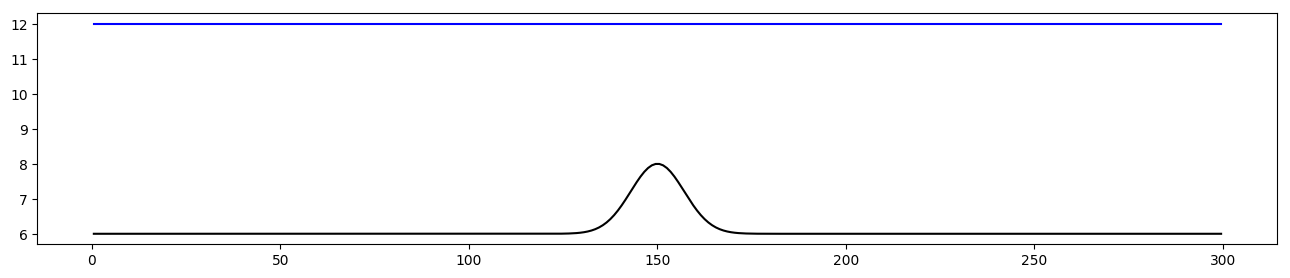

In [2]:
# Set up the constants

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)

# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z0 = zc.copy() 
fig = plt.figure(figsize=(16, 3))
surf = np.ones(nx) * s
plt.plot(xc, surf, 'b')
plt.plot(xc, zc,'k')

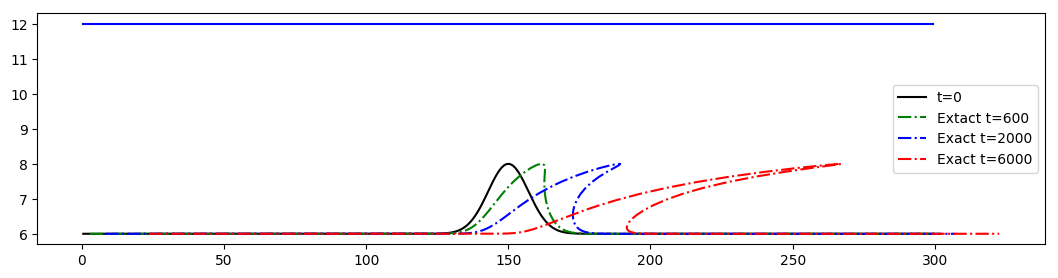

In [3]:
fig = plt.figure(figsize=(13, 3))
from schemes.weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,2000.)
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)
np.shape(x_600),np.shape(z_a600)

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, surf, 'b')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()


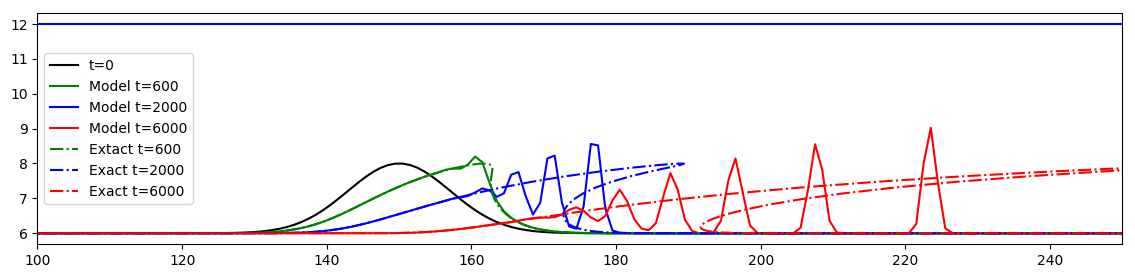

In [6]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.25 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

        

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

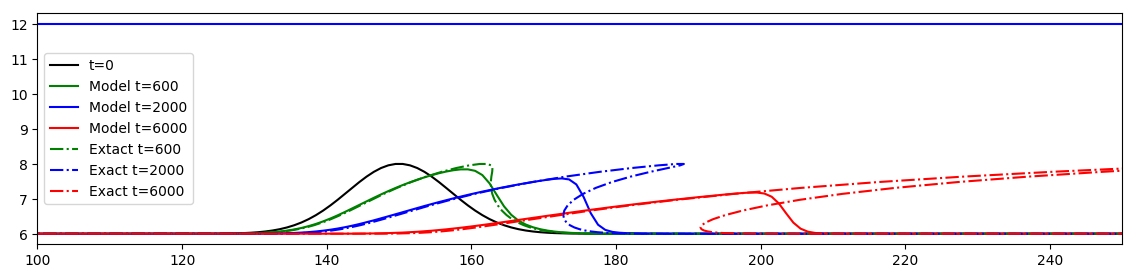

In [23]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 1 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

qbedload = np.zeros(len(xc))
cntr = 0

zc = z0.copy()
#--------------------------------
#  Run the model
#--------------------------------
time_series = collections.OrderedDict()
time = 0
for n in range(1,nt):  s
    zn = zc.copy() 
    alpha = np.zeros(nx)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        zloc = get_stencil(zn,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            alpha[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            alpha[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        
        
        qloc = get_stencil(qbedload,i-1,i+2)  
        #zc[i] = zn[i]-(1./(1.-nP))*dt/(dx*2.)*(qloc[2] - qloc[0])
        zc[i] = zn[i]-(1./(1.-nP))*(dt/dx)*0.5*( (1+alpha[i])*(qloc[1] - qloc[0])  + (1 - alpha[i])*(qloc[2] - qloc[1]))
    
    bed_max_delta = np.max(np.abs(zn - zc))
        
    slope = np.gradient(zc,dx)
    
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
        

    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()
        

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()


Grid dx = 1.0
Grid nx = 300
57.20592950005084


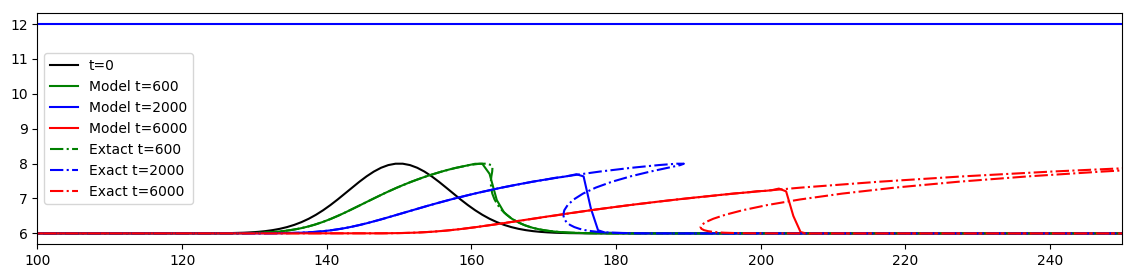

In [28]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

#--------------------------------
# Run the model
#--------------------------------

simTime = 6000. # Runtime
dt = 1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

from timeit import default_timer as timer

start = timer()

# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    # Now iterate over the domain
    for i in range(0,nx): 
        #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc) != 6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
    
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b

    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()
        
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

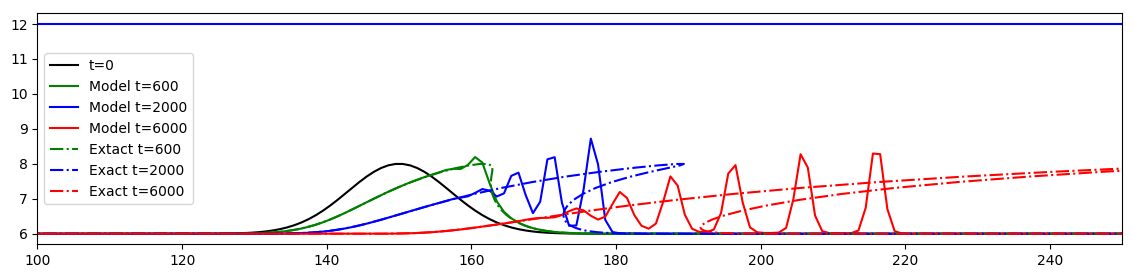

In [25]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.25 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

qbedload = np.zeros(len(xc))
cntr = 0

zc = z0.copy()
#--------------------------------
#  Run the model
#--------------------------------
time_series = collections.OrderedDict()
time = 0
for n in range(1,nt):  
    zn = zc.copy() 
    zhatn = zc.copy() 
    alpha = np.zeros(nx)
        
    # Need the sign of the phase speed
    # Need to check this out
      
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zhatn[i] = zn[i]-(1./(1.-nP))*dt/(dx)*(qloc[1] - qloc[0])
        
    # Update the flow depth, velocity and bedload
    h = s - zhatn
    u = Q/h
    qbedload = a*u**b
        
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zc[i] = 0.5*(zhatn[i]+zn[i]) - (1/(1.-nP))*dt/(dx*2.)*(qloc[2] - qloc[1])
        
    
    bed_max_delta = np.max(np.abs(zn - zc))
    

        
    slope = np.gradient(zc,dx)
    
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
        
    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()
        

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

Grid dx = 1.0
Grid nx = 300
Time: 157.6916020999779 seconds


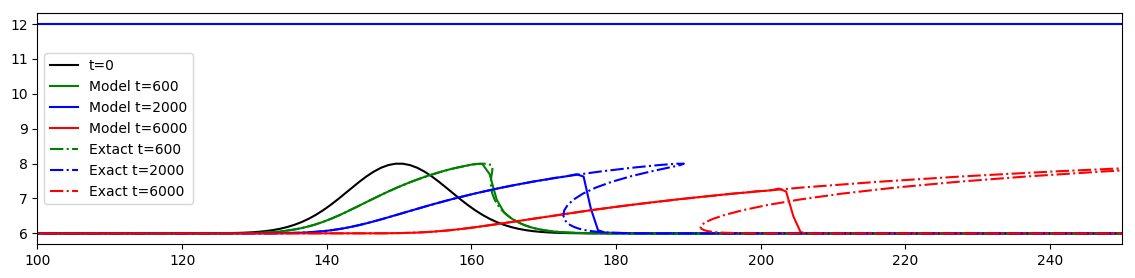

In [27]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

#--------------------------------
# Run the model
#--------------------------------

simTime = 6000. # Runtime
dt = 1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

from timeit import default_timer as timer

start = timer()
# ...


# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    znp1  = zc.copy() 
    znp12  = zc.copy() 
    znp2  = zc.copy() 
    znp32  = zc.copy() 
    
    ## Step 1
    for i in range(0,nx): 
        zloc = get_stencil(zn,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp1[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # Update the flow depth, velocity and bedload
    h = s - znp1
    u = Q/h
    qbedload = a*u**b
    
    # -------------------------
    # Step 2
    # -------------------------
    for i in range(0,nx): 
        zloc = get_stencil(znp1,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp2[i] = znp1[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # -------------------------
    # Step 3
    # -------------------------
    znp12 = 0.75*zn + 0.25*znp2
    
    # Update the flow depth, velocity and bedload
    h = s - znp12
    u = Q/h
    qbedload = a*u**b
        
    
    # -------------------------
    # Step 4
    # -------------------------
    for i in range(0,nx): 
        zloc = get_stencil(znp12,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp32[i] = znp12[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # -------------------------
    # Step 5
    # -------------------------
    zc = (1./3.)*zn + (2./3.)*znp32
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b

    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()

end = timer()
print('Time: {0} seconds'.format(end - start)) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

In [7]:
get_Max_Phase_Speed(qbedload,zc,nP)*dt/dx

0.00492655828485196